## RLDynamicHedger Inference Evaluation of RL models for different use cases (version 2)
 - This notebook is used to demo the 4 RL models inference hedging performance results for a number of use cases:
     - low expiry
     - high expiry
     - low hedging frequency
     - high hedging frequency
     - high transaction cost (low risk aversion)
     - low transaction cost (high risk aversion)

#### Imports

#### Set current working directory..

In [1]:
import os, sys
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Optional, Dict, List, Any
import time


SEED = 100
NEW_LINE = "\n"
LINE_DIVIDER = "==========" * 5

plt.style.use(['science','no-latex'])
np.random.seed(SEED)

#### Import the experiment use cases module

In [2]:
from experiment_use_cases import run_scenario_map, getRunScenarioParams

Current path is: C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final...

Root folder: C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\scripts\..


C:\Users\ADE\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ROOT_PATH = "../"
os.chdir(ROOT_PATH)
print(f"Current path is: {os.getcwd()}...{NEW_LINE}")

Current path is: C:\Development\Training\MLI Certificate of Finance\Final-Project\Project...



#### Libaries for RLDynamicHedger


In [4]:
sys.path.insert(2, ROOT_PATH)

from src.main.environment.env import DynamicHedgingEnv
import src.main.configs_global as configs
from src.main.utility.utils import Helpers
from src.main.utility.logging import Logger
from src.main.market_simulator.parameters import Parameters
from src.main.utility.utils import Helpers
from src.main.utility.enum_types import HedgingType, RLAgorithmType
import src.main.configs_rl as configs2
from src.main.rl_algorithms.hyper_parameter_tuning.td3_hyper_parameter_tuning import TD3HyperParameterTuning
from src.main.rl_algorithms.hyper_parameter_tuning.ddpg_hyper_parameter_tuning import DDPGHyperParameterTuning
from src.main.rl_algorithms.hyper_parameter_tuning.sac_hyper_parameter_tuning import SACHyperParameterTuning
from src.main.rl_algorithms.hyper_parameter_tuning.ppo_hyper_parameter_tuning import PPOHyperParameterTuning
from src.main.rl_algorithms.hyper_parameter_tuning.base_hyper_parameter_tuning import BaseHyperParameterTuning
from src.main.rl_algorithms.train_evaluate_test.td3_algorithm import TD3TrainAlgorithm
from src.main.rl_algorithms.train_evaluate_test.ddpg_algorithm import DDPGTrainAlgorithm
from src.main.rl_algorithms.train_evaluate_test.sac_algorithm import SACTrainAlgorithm
from src.main.rl_algorithms.train_evaluate_test.ppo_algorithm import PPOTrainAlgorithm
from src.main.rl_algorithms.train_evaluate_test.base_algorithms import BaseAlgorithm

#### Set demo parameters

In [5]:
HEDGING_TYPES = [HedgingType.gbm, HedgingType.sabr, HedgingType.heston]
ALGO_TYPES = [RLAgorithmType.sac, RLAgorithmType.ppo, RLAgorithmType.ddpg, RLAgorithmType.td3]
MODEL_USE_CASE = "low_moneyness"

In [6]:
#TUNED_RL_MODEL_PATH = "./model/trained-tuned-models/sac/test_gbm_v2/best_model.zip"
# PLOT_PATHS_PER_HEDGE_TYPE

#### Implement the class to do the evaluation

In [7]:
class HedgerEvaluator:
    """
    Evaluate the selected RL hedger
    """
    def __init__(
        self,
        rl_type: RLAgorithmType,
        hedging_type: HedgingType,
        parameters: Parameters,
        model_use_case: str
    ):
        """
        Constructor
        :param rl_type: RL algorithm type
        :param hedging_type: Hedging type
        :param parameters: Simulation parameters
        :param model_use_case: Model use case
        """
        self._logger = Logger.getLogger()
        self._current_path = os.getcwd()
        print(f"Current path is: {self._current_path}...{configs.NEW_LINE}")
        self._env_name = "RL Delta Hedger"
       
        self._env = DynamicHedgingEnv(parameters=parameters)
        self._parameters = parameters
        # self._env.prameters = parameters
        self._rl_algorithm_type = rl_type       
        self._expiry_level = "high" if self._parameters.is_high_expiry_level else "low"
        self._model_use_case = model_use_case
        self._result_df = None
        self._simulation_path_index = -1
        
        self._logger.info(f"Evaluating hedging performance for {self._rl_algorithm_type} RL agent and for {self._parameters.hedging_type.name} simulation use case")
        self._logger.info(f"This evaluation for themodel use case {self._model_use_case} ")
        print(f"Hedging experiment settings:")
        print(f's0: {self._parameters.start_stock_price}\nK: {self._parameters.strike_price}\nT: {self._parameters.option_expiry_time}\nvol: {self._parameters.volatility}\nsteps:' 
        f'{self._parameters.n_time_steps}\nHedging Frequency: {self._parameters.trading_frequency}\nExpiry level: {self._expiry_level}')
        self._agent = self._createRLAgent()
        

    def _createRLAgent(self) -> BaseAlgorithm:
        """
        Creates the RL algorithm
        """
        match self._rl_algorithm_type:
            case RLAgorithmType.td3:
                return TD3TrainAlgorithm(
                    self._env,
                    hedging_type=self._parameters.hedging_type,
                    model_use_case=self._model_use_case
                )
            case RLAgorithmType.ddpg:
                return DDPGTrainAlgorithm(
                    self._env,
                    hedging_type=self._parameters.hedging_type,
                    model_use_case=self._model_use_case
                )
            case RLAgorithmType.sac:
                return SACTrainAlgorithm(
                    self._env,
                    hedging_type=self._parameters.hedging_type,
                    model_use_case=self._model_use_case
                )
            case RLAgorithmType.ppo:
                return PPOTrainAlgorithm(
                        self._env,
                        hedging_type=self._parameters.hedging_type,
                        model_use_case=self._model_use_case
                    )
            case _:
                raise Exception("Invalid RL algorithm type!!")

    def evaluate(self) -> pd.DataFrame:
        """
        Evaluates the RL agent
        """
        self._results_df = self._agent.evaluate()
        self._simulation_path_index = self._agent.simulation_path_index
        return self._results_df

    def createPlots(
        self,
        is_plot_to_screen: bool = False,
        plot_name: str = ""
    ):
        """
        Create the evaluation plots
        """
        self._agent.createEvaluationPlots(is_plot_to_screen, plot_name)
        
        


#### Run the inference experiments

In [8]:
def runExperiment(
    rl_algo_type: RLAgorithmType, 
    hedging_type: HedgingType,
    model_use_case: str
):
    """
    Runs the experiment scenario
    :param rl_algo_type: RL algorithm
    :param hedging_type: Hedging type
    :param model_use_case: Model use case
    """
    print(f"Running experiment for RL agent: {rl_algo_type.name} and hedging simulation type: {hedging_type.name}")
    parameter_settings_data = Helpers.getParameterSettings(configs.DEFAULT_SETTINGS_NAME)
    parameters = Parameters(**parameter_settings_data)
    parameters.hedging_type = hedging_type
    run_scenario_parameters = getRunScenarioParams(parameters, scenario=model_use_case)
    print(f"Parameters used to run the simultion use case are:\n\n{run_scenario_parameters}\n\n")
    evaluator = HedgerEvaluator(rl_algo_type, hedging_type, parameters, model_use_case)
    results_df = evaluator.evaluate()
    print(f"Sample RL agent evaluation results are:\n {results_df.head()}")
    selected_columns = ["bs_delta", "rl_delta", "bs_option_price", "rl_option_price"]
    print(results_df[selected_columns].head(5))
    evaluator.createPlots(is_plot_to_screen=True)

def runExperiments(model_use_case: str = MODEL_USE_CASE):
    """
    Runs the experiments for a specified scenario
    """
    
    for hedging_type in HEDGING_TYPES:
        for rl_algo in ALGO_TYPES:
            runExperiment(rl_algo, hedging_type, model_use_case)
            print(f"\n{LINE_DIVIDER}\n\n\n\n")
    

#### Run the experiments

2025-04-22 23:40:27,533 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certif

Running experiment for RL agent: sac and hedging simulation type: gbm
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, hes

2025-04-22 23:40:27,653 - INFO - caching.py:option_price_data - : Getting option price data from data/12month/1d/OTM/option_price_gbm_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:88
2025-04-22 23:40:27,761 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_gbm_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:27,871 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.sac RL agent and for gbm simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|███████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 835.32it/s]
2025-04-22 23:40:31,727 - INFO - base_algorithms.py:evaluate - : Created evaluation results for sac with gbm hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:31,729 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.002332         1.368736   
1                  0.001498    -0.029199         1.413796   
2                  0.005800    -0.302959         1.776643   
3                  0.000264    -0.247984         2.081672   
4                  0.001172     0.183881         1.830273   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             23.348248  0.172390  0.304470            81.180297   
1             70.248866  0.174147  0.881171            81.328291   
2             72.402495  0.180126  0.907590            81.738369   
3             62.794125  0.184902  0.790515            82.068065   
4             17.821362  0.179131  0.240402            81.749711   

   bs_option_price   rewards  
0         1.371068  0.002332  
1         1.388427 -0.029242  
2         1.452616 -0.307549  
3         1.504125 -0.251059  
4         1.437516  0.182191

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for sac hedger agent at the path: ./Plots/RL_Delta_Hedger_sac_gbm/sac_all_distributions_.png


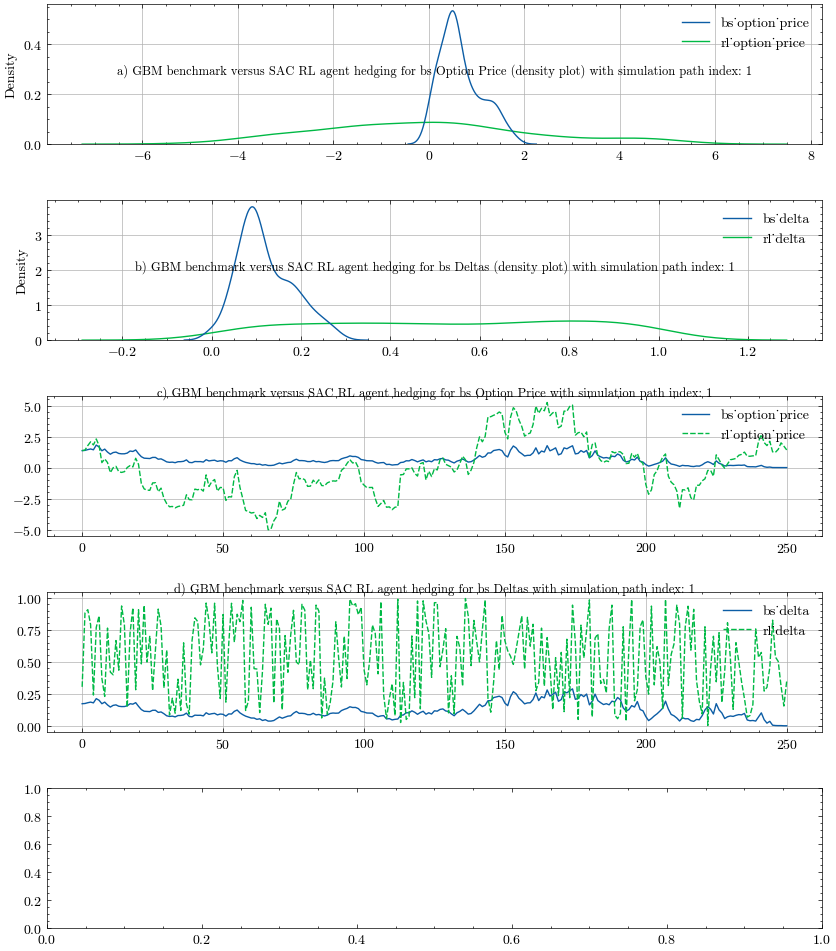

2025-04-22 23:40:35,915 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certif






Running experiment for RL agent: ppo and hedging simulation type: gbm
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25

C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:36,221 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.ppo RL agent and for gbm simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:40:36,223 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:40:36,229 - INFO - ppo_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL DELTA HEDGER in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\ppo_algorithm.py:43
2025-04-22 23:40:36,238 - INFO - ppo_algorithm.py:__init__ - : This RL environment uses a PPO RL algor

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1333.25it/s]
2025-04-22 23:40:36,526 - INFO - base_algorithms.py:evaluate - : Created evaluation results for ppo with gbm hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:36,528 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.002332         1.368736   
1                  0.008523    -0.139158         1.516730   
2                  0.000000    -0.345888         1.935331   
3                  0.010100     0.041409         1.935331   
4                  0.000000    -0.066610         1.945431   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             79.811561  0.172390       1.0            81.180297   
1             79.803038  0.174147       1.0            81.328291   
2             -1.935331  0.180126      -0.0            81.738369   
3             -1.945431  0.184902      -0.0            82.068065   
4             -1.945431  0.179131      -0.0            81.749711   

   bs_option_price   rewards  
0         1.371068  0.002332  
1         1.388427 -0.140126  
2         1.452616 -0.351870  
3         1.504125  0.041323  
4         1.437516 -0.066832

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for ppo hedger agent at the path: ./Plots/RL_Delta_Hedger_ppo_gbm/ppo_all_distributions_.png


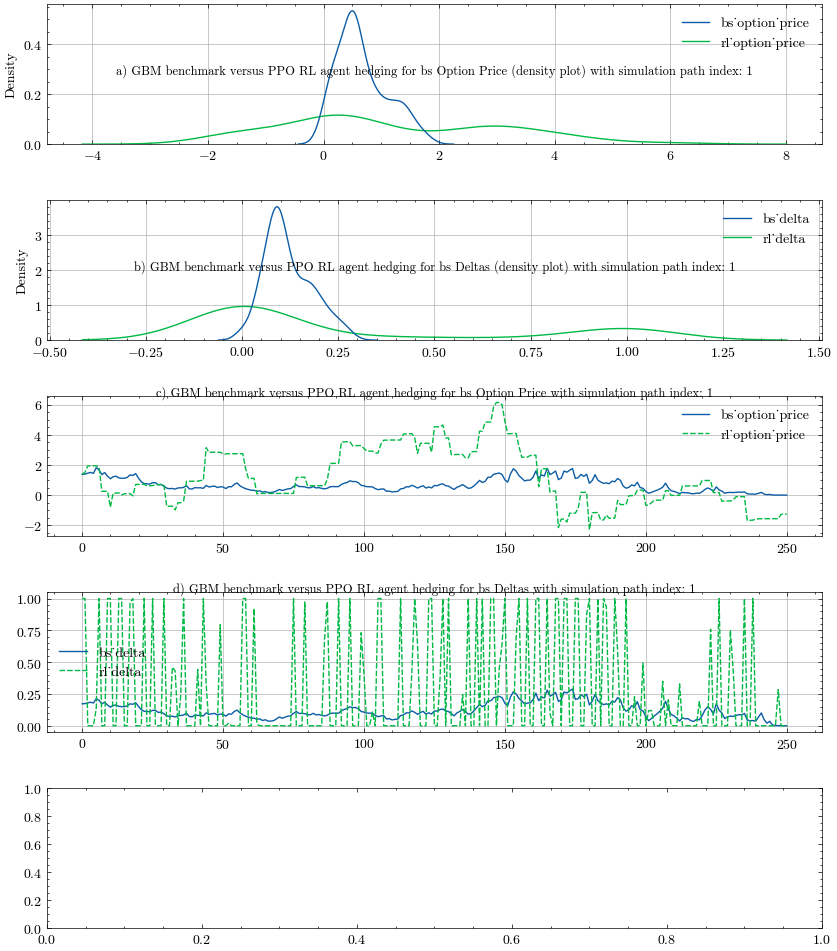

2025-04-22 23:40:40,339 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certif






Running experiment for RL agent: ddpg and hedging simulation type: gbm
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.2

2025-04-22 23:40:40,552 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_gbm_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:40,636 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.ddpg RL agent and for gbm simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:40:40,636 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:40:40,656 - INFO - ddpg_algorithm.py:__init__ - : Start of Reinforcement learning for en

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1587.26it/s]
2025-04-22 23:40:40,895 - INFO - base_algorithms.py:evaluate - : Created evaluation results for ddpg with gbm hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:40,898 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.002332         1.368736   
1                  0.001538     0.015623         1.368934   
2                  0.000028     0.062472         1.372161   
3                  0.000006     0.049940         1.373751   
4                  0.000027    -0.064282         1.371403   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             -1.260300  0.172390  0.001336            81.180297   
1             -1.035448  0.174147  0.004119            81.328291   
2             -0.984778  0.180126  0.004740            81.738369   
3             -0.766823  0.184902  0.007396            82.068065   
4             -0.521608  0.179131  0.010395            81.749711   

   bs_option_price   rewards  
0         1.371068  0.002332  
1         1.388427  0.015611  
2         1.452616  0.062277  
3         1.504125  0.049816  
4         1.437516 -0.064489

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for ddpg hedger agent at the path: ./Plots/RL_Delta_Hedger_ddpg_gbm/ddpg_all_distributions_.png


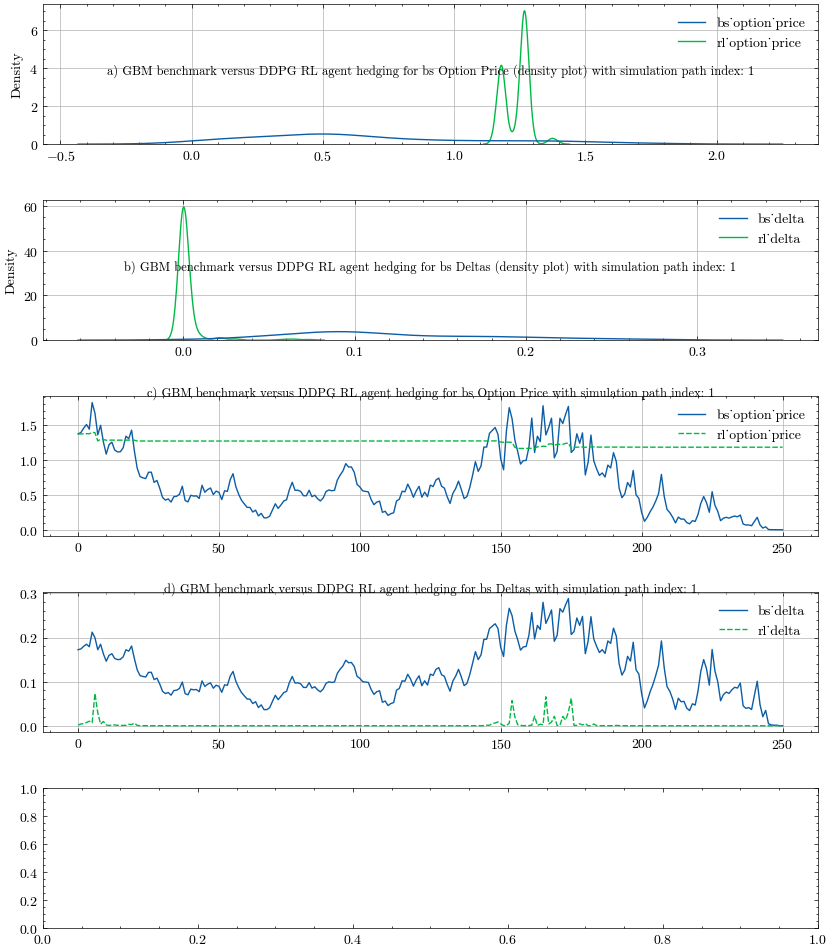

2025-04-22 23:40:44,590 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certif






Running experiment for RL agent: td3 and hedging simulation type: gbm
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.gbm: 1>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25

2025-04-22 23:40:44,808 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_gbm_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:44,902 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.td3 RL agent and for gbm simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:40:44,902 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:40:44,917 - INFO - td3_algorithm.py:__init__ - : Start of Reinforcement learning for envi

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1792.13it/s]
2025-04-22 23:40:45,113 - INFO - base_algorithms.py:evaluate - : Created evaluation results for td3 with gbm hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:45,115 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.002332         1.368736   
1                  0.001086     0.009410         1.375598   
2                  0.000394     0.028636         1.411844   
3                  0.000169     0.017494         1.446084   
4                  0.000121    -0.030195         1.409718   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0              2.395239  0.172390  0.046366            81.180297   
1              5.596406  0.174147  0.085740            81.328291   
2              6.978891  0.180126  0.102658            81.738369   
3              7.972184  0.184902  0.114764            82.068065   
4              9.057351  0.179131  0.128039            81.749711   

   bs_option_price   rewards  
0         1.371068  0.002332  
1         1.388427  0.009406  
2         1.452616  0.028595  
3         1.504125  0.017479  
4         1.437516 -0.030241

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for td3 hedger agent at the path: ./Plots/RL_Delta_Hedger_td3_gbm/td3_all_distributions_.png


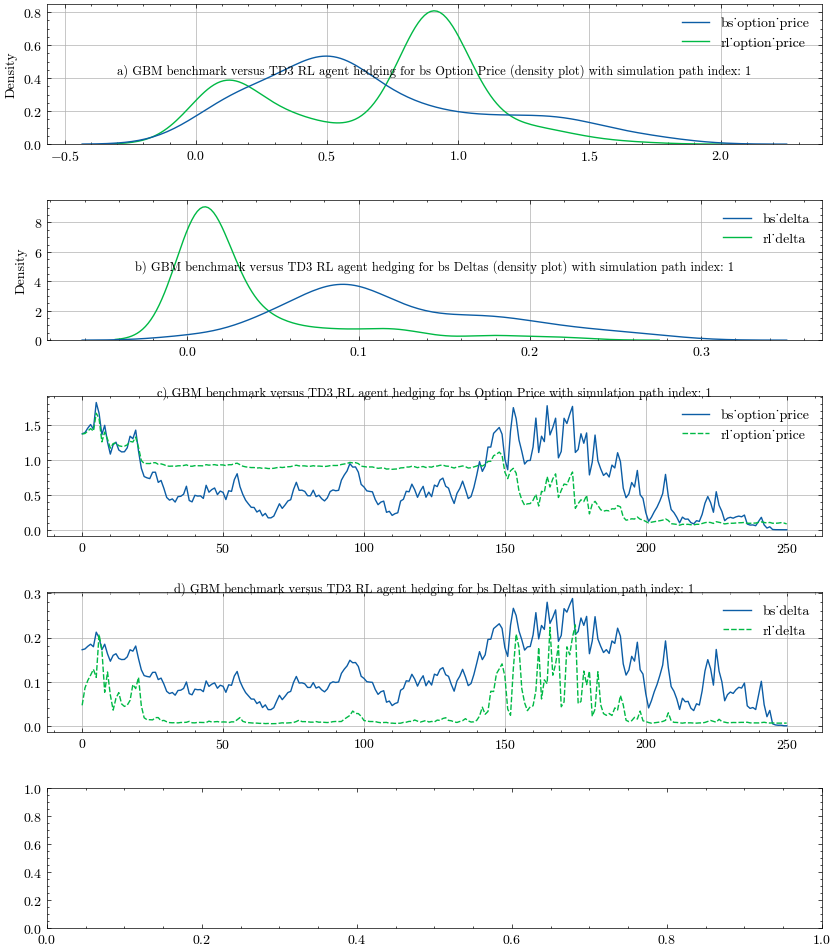

2025-04-22 23:40:48,228 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certi






Running experiment for RL agent: sac and hedging simulation type: sabr
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.

C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:48,527 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.sac RL agent and for sabr simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:40:48,527 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:40:48,540 - INFO - sac_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL DELTA HEDGER in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\sac_algorithm.py:44
2025-04-22 23:40:48,540 - INFO - sac_algorithm.py:__init__ - : This RL environment uses a SAC RL algo

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1029.91it/s]
2025-04-22 23:40:48,855 - INFO - base_algorithms.py:evaluate - : Created evaluation results for sac with sabr hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:48,857 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000    -0.083870         1.357159   
1                  0.005572     1.093712         0.035548   
2                  0.004721    -0.046735         0.722789   
3                  0.001644    -0.122373         0.617876   
4                  0.005571    -0.752690         1.744032   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             56.144112  0.165069  0.708968            81.105548   
1             18.905071  0.142071  0.239095            79.241416   
2              5.429522  0.197082  0.075001            82.092460   
3             50.099349  0.176612  0.629027            80.630699   
4             23.415319  0.207376  0.305331            82.418401   

   bs_option_price   rewards  
0         1.273289 -0.084221  
1         1.050962  1.033901  
2         1.690616 -0.046845  
3         1.460253 -0.123122  
4         1.837647 -0.781017

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for sac hedger agent at the path: ./Plots/RL_Delta_Hedger_sac_sabr/sac_all_distributions_.png


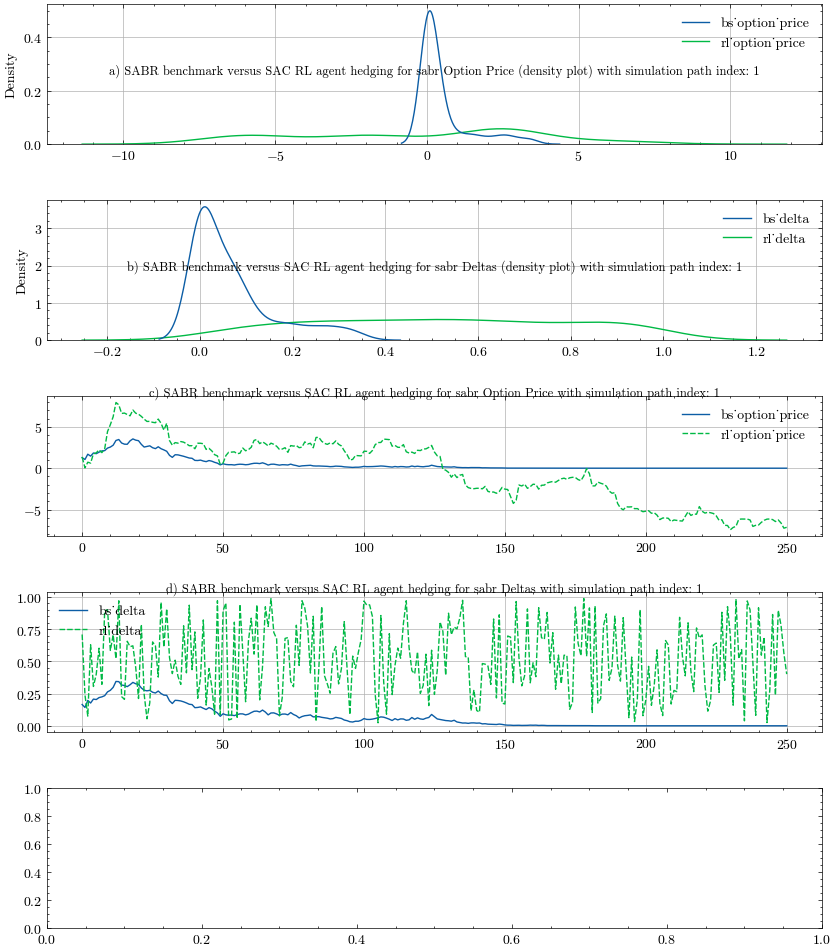

2025-04-22 23:40:52,386 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certi






Running experiment for RL agent: ppo and hedging simulation type: sabr
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.

2025-04-22 23:40:52,603 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_sabr_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:52,699 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.ppo RL agent and for sabr simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:40:52,702 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:40:52,708 - INFO - ppo_algorithm.py:__init__ - : Start of Reinforcement learning for en

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1332.15it/s]
2025-04-22 23:40:52,933 - INFO - base_algorithms.py:evaluate - : Created evaluation results for ppo with sabr hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:52,933 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000    -0.083870         1.357159   
1                  0.001551    -0.223879         1.357159   
2                  0.000000     0.639655         1.358710   
3                  0.010100     1.221298        -0.103051   
4                  0.000000    -1.410308         1.694751   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             -1.357159  0.165069      -0.0            81.105548   
1             -1.358710  0.142071      -0.0            79.241416   
2             80.733750  0.197082       1.0            82.092460   
3             80.723650  0.176612       1.0            80.630699   
4             -1.694751  0.207376      -0.0            82.418401   

   bs_option_price   rewards  
0         1.273289 -0.084221  
1         1.050962 -0.226385  
2         1.690616  0.619197  
3         1.460253  1.146720  
4         1.837647 -1.509757

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for ppo hedger agent at the path: ./Plots/RL_Delta_Hedger_ppo_sabr/ppo_all_distributions_.png


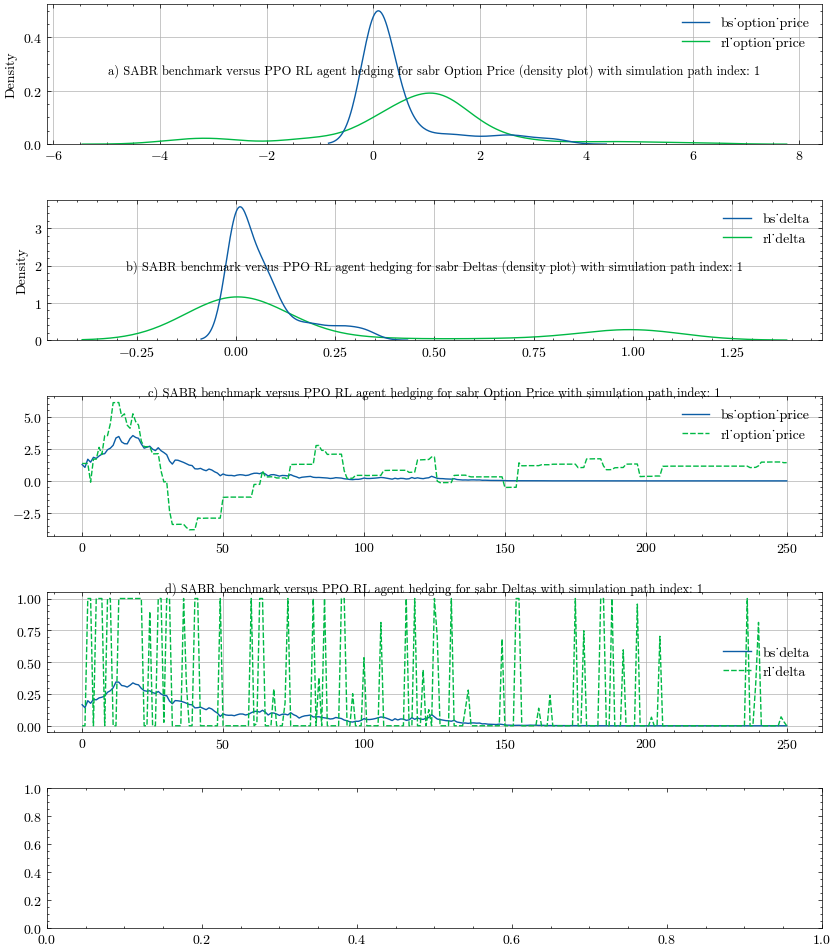

2025-04-22 23:40:56,246 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certi






Running experiment for RL agent: ddpg and hedging simulation type: sabr
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0

C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:40:56,528 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.ddpg RL agent and for sabr simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:40:56,528 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:40:56,544 - INFO - ddpg_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL DELTA HEDGER in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\ddpg_algorithm.py:42
2025-04-22 23:40:56,575 - INFO - ddpg_algorithm.py:__init__ - : This RL environment uses a DDPG RL

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1459.76it/s]
2025-04-22 23:40:56,834 - INFO - base_algorithms.py:evaluate - : Created evaluation results for ddpg with sabr hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:40:56,835 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000    -0.083870         1.357159   
1                  0.001538    -0.221375         1.354669   
2                  0.000009     0.633257         1.362595   
3                  0.000017    -0.229555         1.361779   
4                  0.000334     0.316336         1.422520   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             -1.248823  0.165069  0.001336            81.105548   
1             -1.178644  0.142071  0.002241            79.241416   
2             -1.316257  0.197082  0.000565            82.092460   
3              1.377027  0.176612  0.033967            80.630699   
4             -0.789551  0.207376  0.007684            82.418401   

   bs_option_price   rewards  
0         1.273289 -0.084221  
1         1.050962 -0.223826  
2         1.690616  0.613206  
3         1.460253 -0.232189  
4         1.837647  0.311333

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for ddpg hedger agent at the path: ./Plots/RL_Delta_Hedger_ddpg_sabr/ddpg_all_distributions_.png


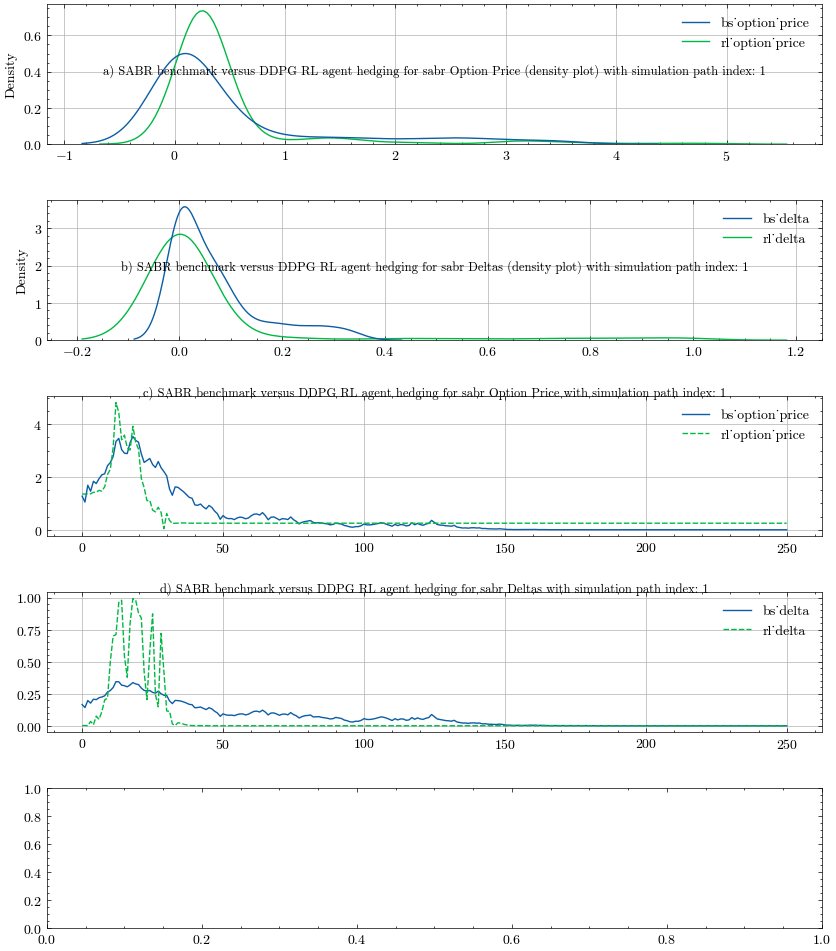

2025-04-22 23:41:00,574 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Certi






Running experiment for RL agent: td3 and hedging simulation type: sabr
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.sabr: 2>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.

C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:41:00,841 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.td3 RL agent and for sabr simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:41:00,841 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:41:00,866 - INFO - td3_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL DELTA HEDGER in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\td3_algorithm.py:44
2025-04-22 23:41:00,868 - INFO - td3_algorithm.py:__init__ - : This RL environment uses a TD3 RL algo

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1848.09it/s]
2025-04-22 23:41:01,053 - INFO - base_algorithms.py:evaluate - : Created evaluation results for td3 with sabr hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:41:01,055 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000    -0.083870         1.357159   
1                  0.001086    -0.136982         1.270727   
2                  0.000174     0.457783         1.453512   
3                  0.000270    -0.176932         1.399984   
4                  0.001352     0.069023         1.707273   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0              2.403350  0.165069  0.046366            81.105548   
1              3.778270  0.142071  0.063730            79.241416   
2              1.562196  0.197082  0.036738            82.092460   
3             12.447214  0.176612  0.171739            80.630699   
4              7.891888  0.207376  0.116485            82.418401   

   bs_option_price   rewards  
0         1.273289 -0.084221  
1         1.050962 -0.137920  
2         1.690616  0.447305  
3         1.460253 -0.178497  
4         1.837647  0.068785

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for td3 hedger agent at the path: ./Plots/RL_Delta_Hedger_td3_sabr/td3_all_distributions_.png


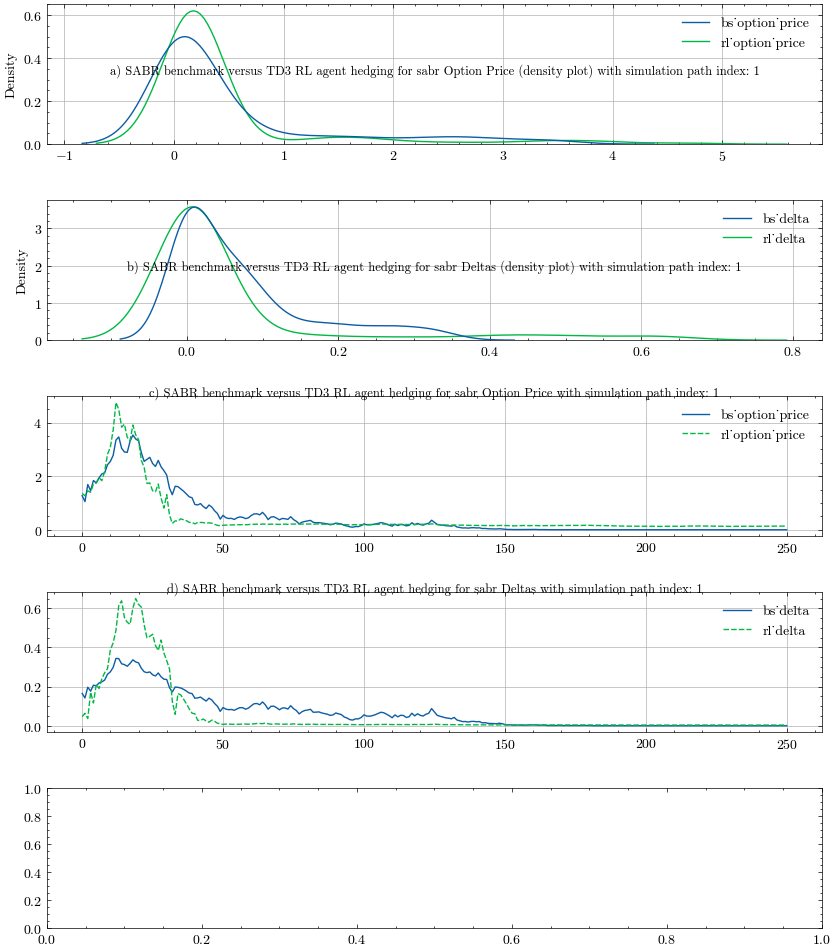

2025-04-22 23:41:03,996 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Cer






Running experiment for RL agent: sac and hedging simulation type: heston
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vo

2025-04-22 23:41:04,217 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_heston_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:41:04,309 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.sac RL agent and for heston simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:41:04,309 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:41:04,323 - INFO - sac_algorithm.py:__init__ - : Start of Reinforcement learning fo

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|███████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 999.41it/s]
2025-04-22 23:41:04,629 - INFO - base_algorithms.py:evaluate - : Created evaluation results for sac with heston hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:41:04,630 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.207021         4.189141   
1                  0.003567    -0.345392         4.744133   
2                  0.003028     0.378916         3.999470   
3                  0.000517    -0.408214         4.519599   
4                  0.001921     0.350966         3.075455   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             51.217154  0.333749  0.706444            78.429871   
1             27.300026  0.343468  0.404564            79.215485   
2             31.297498  0.324423  0.456273            77.366013   
3             16.245330  0.332432  0.264530            78.499329   
4             40.881582  0.274310  0.601863            73.038094   

   bs_option_price   rewards  
0         4.396162  0.204878  
1         4.609329 -0.351357  
2         4.243044  0.371738  
3         4.352448 -0.416546  
4         3.260674  0.344808

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for sac hedger agent at the path: ./Plots/RL_Delta_Hedger_sac_heston/sac_all_distributions_.png


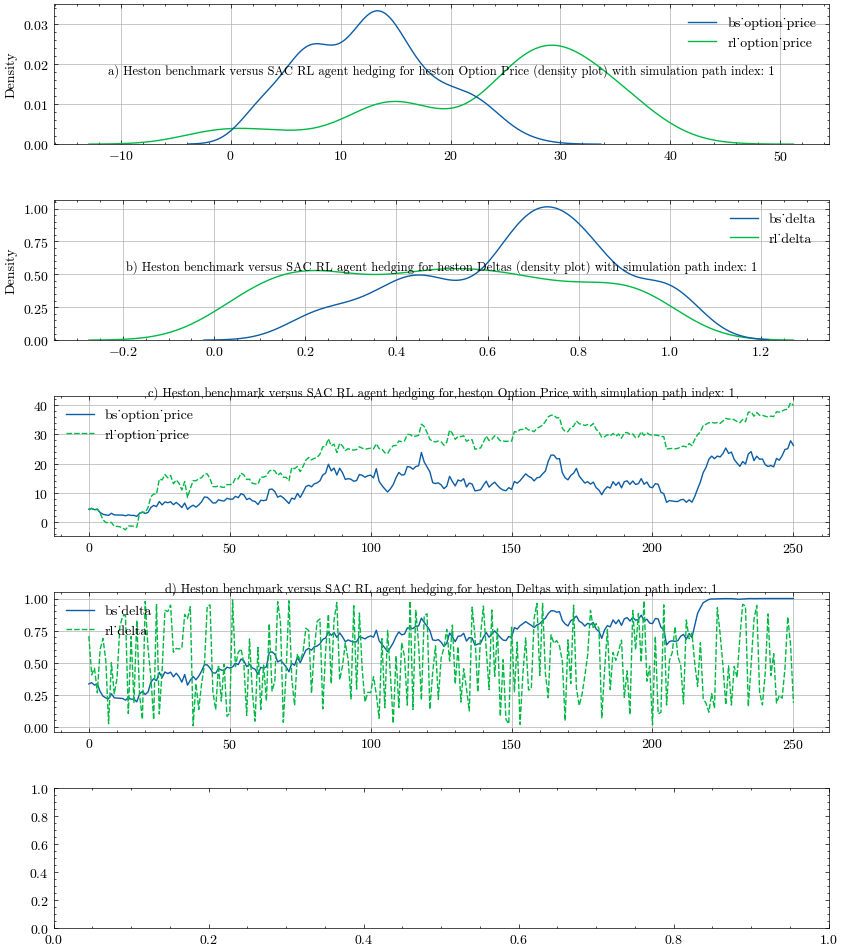

2025-04-22 23:41:08,262 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Cer






Running experiment for RL agent: ppo and hedging simulation type: heston
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vo

2025-04-22 23:41:08,512 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_heston_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:41:08,606 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.ppo RL agent and for heston simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:41:08,606 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:41:08,627 - INFO - ppo_algorithm.py:__init__ - : Start of Reinforcement learning fo

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1478.75it/s]
2025-04-22 23:41:08,836 - INFO - base_algorithms.py:evaluate - : Created evaluation results for ppo with heston hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:41:08,838 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.207021         4.189141   
1                  0.005865    -0.526570         4.923013   
2                  0.000659     1.482528         3.079406   
3                  0.010100     0.099305         3.080065   
4                  0.000000    -1.091774         3.090165   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             69.075210  0.333749  0.934138            78.429871   
1             74.286606  0.343468  1.000000            79.215485   
2             -3.080065  0.324423 -0.000000            77.366013   
3             -3.090165  0.332432 -0.000000            78.499329   
4             -3.090165  0.274310 -0.000000            73.038094   

   bs_option_price   rewards  
0         4.396162  0.204878  
1         4.609329 -0.540434  
2         4.243044  1.372633  
3         4.352448  0.098811  
4         3.260674 -1.151373

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for ppo hedger agent at the path: ./Plots/RL_Delta_Hedger_ppo_heston/ppo_all_distributions_.png


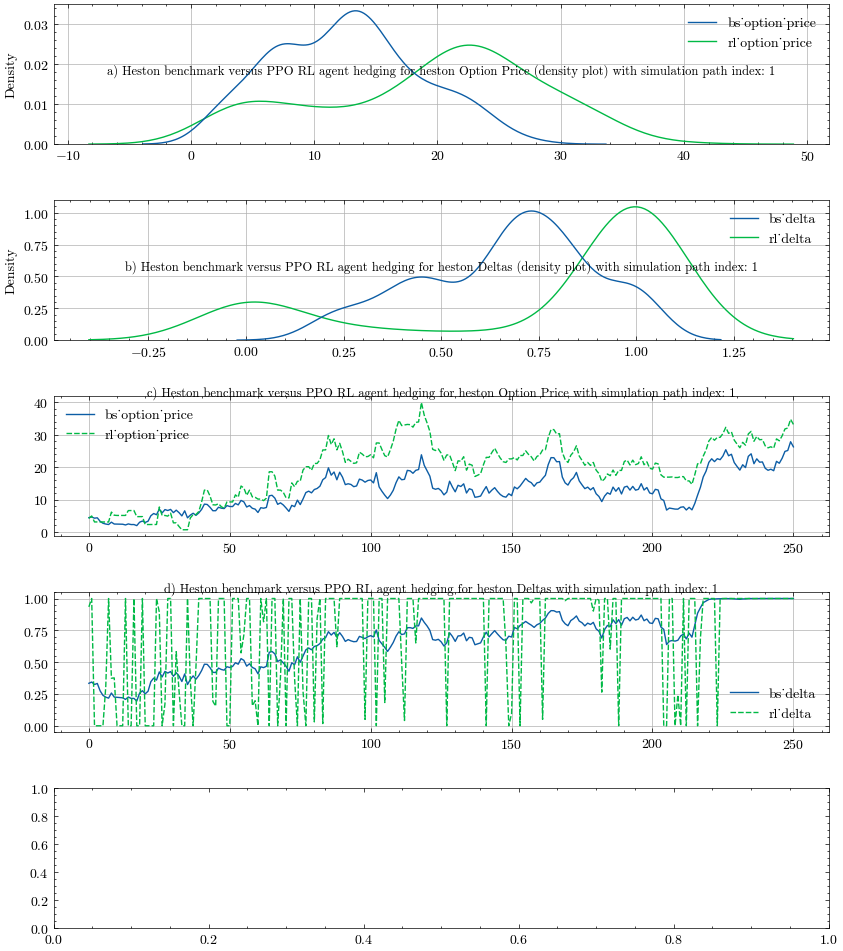

2025-04-22 23:41:12,512 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Cer






Running experiment for RL agent: ddpg and hedging simulation type: heston
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_v

C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:41:12,778 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.ddpg RL agent and for heston simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:41:12,778 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:41:12,797 - INFO - ddpg_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL DELTA HEDGER in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\ddpg_algorithm.py:42
2025-04-22 23:41:12,799 - INFO - ddpg_algorithm.py:__init__ - : This RL environment uses a DDPG 

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1768.21it/s]
2025-04-22 23:41:13,000 - INFO - base_algorithms.py:evaluate - : Created evaluation results for ddpg with heston hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:41:13,002 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.207021         4.189141   
1                  0.003511     0.208743         4.190054   
2                  0.000004    -0.364970         4.192245   
3                  0.000001     0.108457         4.193196   
4                  0.000004    -1.089242         4.190662   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             -4.097983  0.333749  0.001162            78.429871   
1             -4.137037  0.343468  0.000714            79.215485   
2             -4.127626  0.324423  0.000835            77.366013   
3             -4.156753  0.332432  0.000464            78.499329   
4             -4.150462  0.274310  0.000550            73.038094   

   bs_option_price   rewards  
0         4.396162  0.204878  
1         4.609329  0.206565  
2         4.243044 -0.371630  
3         4.352448  0.107869  
4         3.260674 -1.148565

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for ddpg hedger agent at the path: ./Plots/RL_Delta_Hedger_ddpg_heston/ddpg_all_distributions_.png


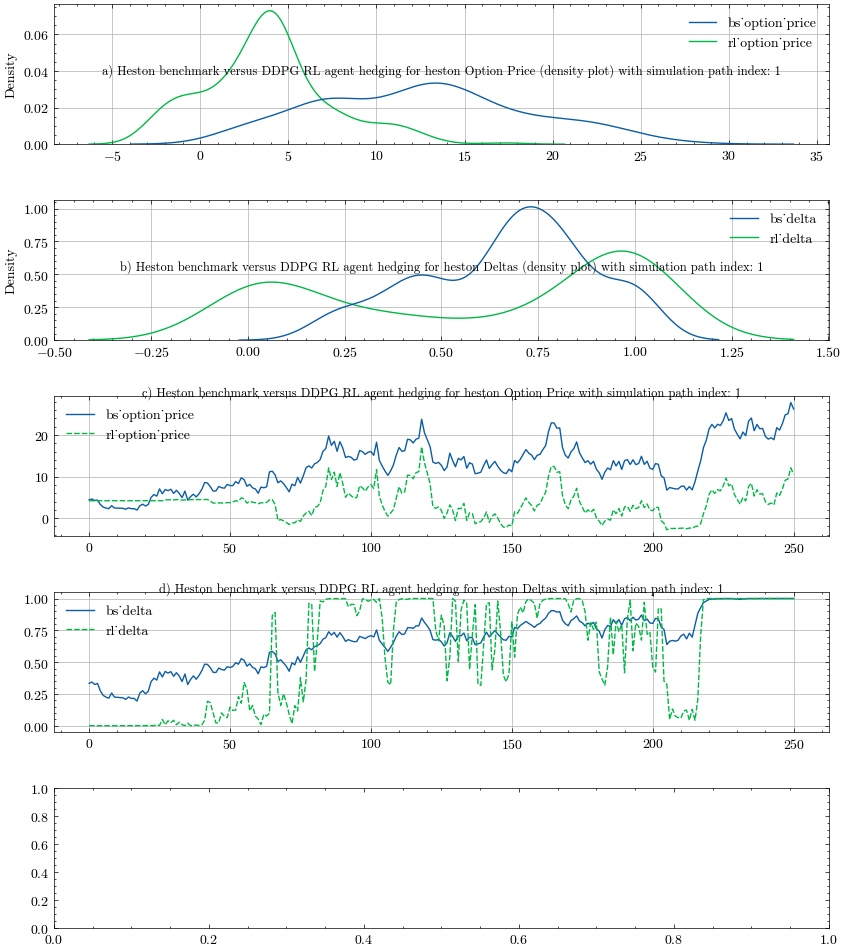

2025-04-22 23:41:18,829 - INFO - env.py:__init__ - : parameters:
Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vol=0.25, heston_start_vol=0.2)
 in C:\Development\Training\MLI Cer






Running experiment for RL agent: td3 and hedging simulation type: heston
Parameters used to run the simultion use case are:

Parameters(n_paths=1000, n_time_steps=252, n_days_per_year=252, trading_frequency=1, option_expiry_time=1.0, start_stock_price=80.0, strike_price=100, volatility=0.2, start_volatility=0.2, volatility_of_volatility=0.6, risk_free_rate=0.0, dividend_rate=0.0, return_on_stock=0.05, cost_per_traded_stock=0.01, rho=-0.4, stdev_coefficient=1.5, central_difference_spacing=0.01, notional=100, is_reset_path=False, is_test_env=True, hedging_type=<HedgingType.heston: 3>, maturity_in_months=12, n_business_days=20, volatility_mean_reversion=1.0, long_term_volatility=0.04, volatility_correlation=-0.7, hedging_time_step=0.003968253968253968, trading_cost_parameter=0.003, risk_averse_level=0.1, is_include_option_price_feature=True, epsilon=1.0, tick_size=0.01, is_in_the_money='OTM', is_high_expiry_level=False, frequency_level='low', evaluation_path_index=0, heston_vol_of_vo

2025-04-22 23:41:19,068 - INFO - caching.py:option_delta_data - : Getting option delta data from data/12month/1d/OTM/option_delta_heston_simulation.csv in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\market_simulator\caching.py:114
C:\Users\ADE\miniconda3\envs\hedging_env_3\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-22 23:41:19,210 - INFO - 3065666430.py:__init__ - : Evaluating hedging performance for RLAgorithmType.td3 RL agent and for heston simulation use case in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:33
2025-04-22 23:41:19,211 - INFO - 3065666430.py:__init__ - : This evaluation for themodel use case low_moneyness  in C:\Users\ADE\AppData\Local\Temp\ipykernel_5864\3065666430.py:34
2025-04-22 23:41:19,222 - INFO - td3_algorithm.py:__init__ - : Start of Reinforcement learning fo

Hedging experiment settings:
s0: 80.0
K: 100
T: 1.0
vol: 0.2
steps:252
Hedging Frequency: 1
Expiry level: low


Evaluating RL Algorithm..: 100%|██████████████████████████████████████████████████▊| 250/251 [00:00<00:00, 1206.83it/s]
2025-04-22 23:41:19,483 - INFO - base_algorithms.py:evaluate - : Created evaluation results for td3 with heston hedging type in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:175
2025-04-22 23:41:19,485 - INFO - base_algorithms.py:evaluate - : The results table has columns and rows of 9 and 251 respectively in C:\Development\Training\MLI Certificate of Finance\Final-Project\Project\RLDynamicHedger-Final\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:177


Sample RL agent evaluation results are:
    current_transaction_cost  current_pnl  rl_option_price  \
0                  0.000000     0.207021         4.189141   
1                  0.003152     0.181081         4.218076   
2                  0.000121    -0.320696         4.175517   
3                  0.000336     0.043043         4.241664   
4                  0.000166    -0.864386         4.014446   

   money_market_account  bs_delta  rl_delta  current_stock_price  \
0             -1.300503  0.333749  0.036831            78.429871   
1             -2.263374  0.343468  0.024716            79.215485   
2              0.331648  0.324423  0.058259            77.366013   
3             -0.971160  0.332432  0.041667            78.499329   
4             -0.767412  0.274310  0.044459            73.038094   

   bs_option_price   rewards  
0         4.396162  0.204878  
1         4.609329  0.179441  
2         4.243044 -0.325838  
3         4.352448  0.042950  
4         3.260674 -0.901745

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving the plot for td3 hedger agent at the path: ./Plots/RL_Delta_Hedger_td3_heston/td3_all_distributions_.png


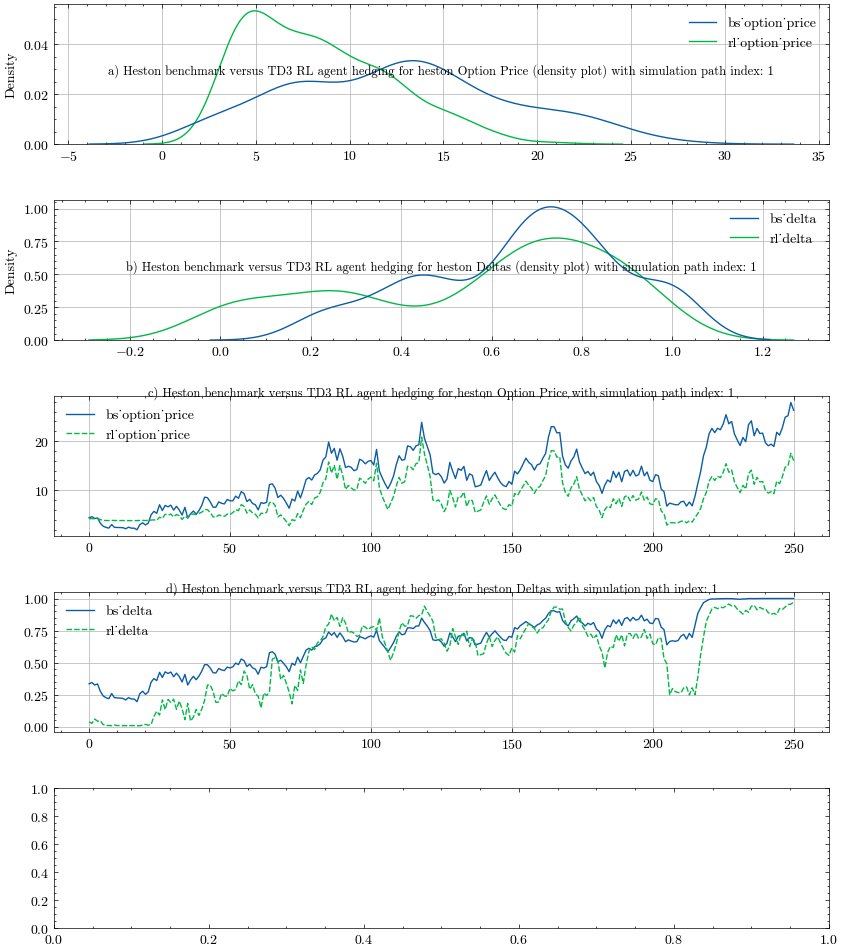

In [9]:
runExperiments()